In [22]:
from read_simulation_data.get_info import get_info
from read_simulation_data.get_foreground_variable import get_foreground_variable
from read_simulation_data.get_background_variable import get_background_variable

import numpy as np
from numpy.fft import fft, fftfreq
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import astropy.units as u
from scipy.integrate import cumtrapz
import h5py

DATA_FOLDER = "/mn/stornext/d10/data/tabjone/data/"
R_SUN = 6.957e10 * u.cm
G = 6.6743e-8 * u.cm**3 / u.g / u.s**2

RUN_NAME = "test_other_ic_4/"
#RUN_NAME = "remove_vz_ic_4/"
constants_dict, global_params_dict, grid_info_dict = get_info(DATA_FOLDER+RUN_NAME)

GAMMA = global_params_dict['GAMMA'][0]
K_B, unit = constants_dict['K_B']
K_B = K_B * u.Unit(unit)
MU, _ = constants_dict['MU']
M_U, unit = constants_dict['M_U']
M_U = M_U * u.Unit(unit)
c_p = K_B / (MU * M_U) /(1.0-1.0/GAMMA)

In [133]:
r, _ = get_background_variable(DATA_FOLDER+RUN_NAME, "r")
r = r / R_SUN.value
constants_dict, global_params_dict, grid_info_dict = get_info(DATA_FOLDER+RUN_NAME)
ny = grid_info_dict['ny'][0]
dy = grid_info_dict['dy'][0]

def get_vz_fft(snap, variable_key, fft_index, normalized=False):
    vz, _, t = get_foreground_variable(DATA_FOLDER+RUN_NAME, snap, variable_key)
    vz = vz / 1e5 # cm/s to km/s
    if normalized:
        vz = vz/(np.sqrt(np.mean(vz**2, axis=1))[:,np.newaxis])

    vz_fft = np.fft.fft(vz[fft_index])
    magnitude_spectrum = np.abs(vz_fft**2)

    spacial_frequency = np.fft.fftfreq(int(ny), d=dy)
    positive_frequencies = spacial_frequency[1:ny//2] # up to Nyquist frequency
    spacial_wavelength = 1/positive_frequencies/R_SUN.value

    return spacial_wavelength, magnitude_spectrum[1:ny//2]

def amplitudes_over_several_snaps(snap_range, variable_key, fft_index, normalized=False):
    amplitudes = []
    for snap in snap_range:
        spacial_wavelength, magnitude_spectrum = get_vz_fft(snap, variable_key, fft_index, normalized)
        amplitudes.append(magnitude_spectrum)

    amplitudes = np.array(amplitudes)

    amplitudes = np.mean(amplitudes, axis=0)

    std_amplitudes = np.std(amplitudes, axis=0)

    return spacial_wavelength, amplitudes, std_amplitudes

In [78]:
def get_pressure_scale_height():
    p0, unit = get_background_variable(DATA_FOLDER+RUN_NAME, "p0")
    p0 = p0 * u.Unit(unit)

    dp0 = (np.roll(p0, -1, axis=0) - np.roll(p0, 1, axis=0))/2
    dp0[0] = p0[1] - p0[0]
    dp0[-1] = p0[-1] - p0[-2]

    dz, unit = grid_info_dict['dz']
    dz = dz * u.Unit(unit)

    Hp = - p0 * dz / dp0
    return Hp

In [ ]:
# time

In [186]:
from tqdm import tqdm

snap_range = range(3100, 3201)

r, _ = get_background_variable(DATA_FOLDER+RUN_NAME, "r")
nz_full = len(r)

ffts_of_radius = []
stds = []
for i in tqdm(range(nz_full)):
    spacial_wavelength, magnitude_spectrum, std = amplitudes_over_several_snaps(snap_range, "vz", i, normalized=True)
    ffts_of_radius.append(magnitude_spectrum)
    stds.append(std)

  0%|          | 0/1028 [00:00<?, ?it/s]/tmp/ipykernel_1449114/2548417777.py:11: RuntimeWarning: invalid value encountered in divide
  vz = vz/(np.sqrt(np.mean(vz**2, axis=1))[:,np.newaxis])
100%|██████████| 1028/1028 [5:22:04<00:00, 18.80s/it] 


In [187]:
Hp = get_pressure_scale_height()
Hp = Hp.to(u.Mm)
spacial_wavelength_mm = spacial_wavelength * u.R_sun
spacial_wavelength_mm = spacial_wavelength_mm.to(u.Mm)

In [188]:
def plot_fft(ax, radius_index):
    ax.set_xlabel("Spacial wavelength [Mm]", fontsize=13)
    ax.set_ylabel("Average power spectrum", fontsize=13)

    our_fft = ffts_of_radius[radius_index]
    our_fft = np.flip(our_fft)

    our_spacial_wl = np.flip(spacial_wavelength_mm)
    x_end_index = np.where(our_spacial_wl.value<=100)[0][-1]

    ax.axvline(Hp.value[radius_index], color='black', linestyle='--', label="Pressure scale height")
    ax.plot(our_spacial_wl[:x_end_index], our_fft[:x_end_index])

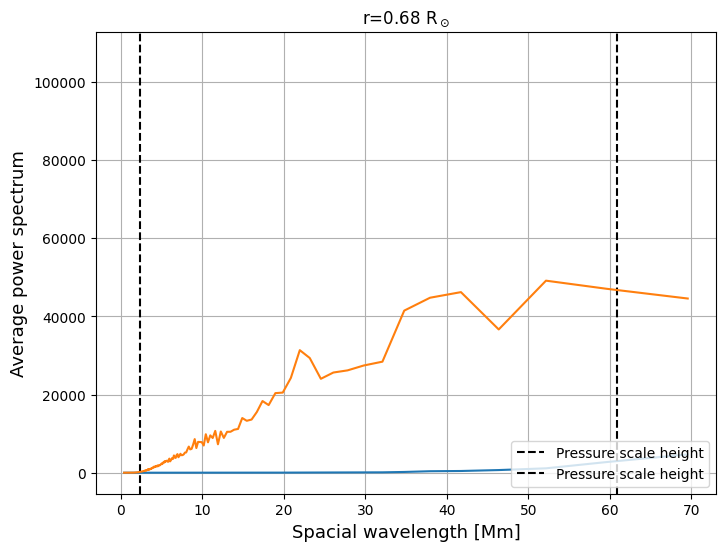

In [189]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

radius_min_index = 3
radius_max_index = -4

def init():
    plot_fft(ax, 3)
    ax.set_title(r"r={:.2f} R$_\odot$".format(r[3]/R_SUN.value))
    ax.grid(True)
    ax.legend(loc='lower right')

def animate(i):
    ax.clear()
    plot_fft(ax, i)
    ax.grid(True)
    ax.legend(loc='lower right')
    ax.set_title(r"r={:.2f} R$_\odot$".format(r[i]/R_SUN.value))


frames = range(radius_min_index, nz_full-3)

anim = FuncAnimation(fig, animate, interval=250, frames=frames, init_func=init)

save_name = "vz_fft.mp4"

anim.save(save_name, writer='ffmpeg', fps=25, extra_args=['-vcodec', 'libx264'])

Text(0.5, 1.0, 'r=0.68 R$_\\odot$')

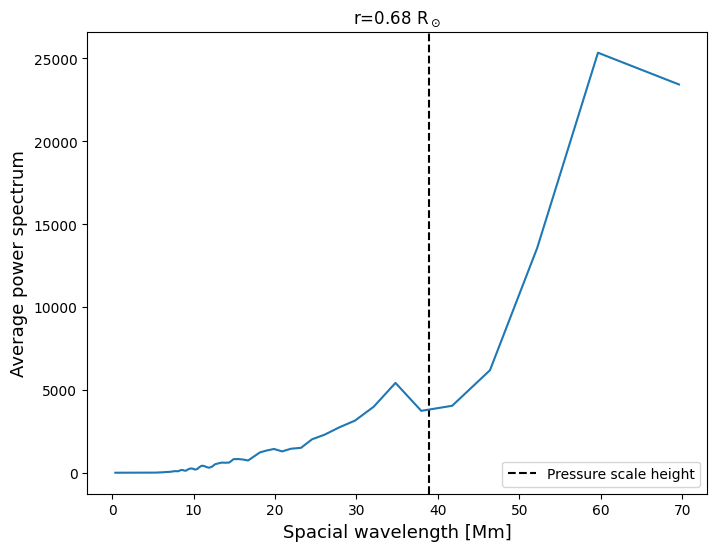

In [181]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plot_fft(ax, 500)
ax.legend(loc="lower right")
ax.set_title(r"r={:.2f} R$_\odot$".format(r[3]/R_SUN.value))

1018


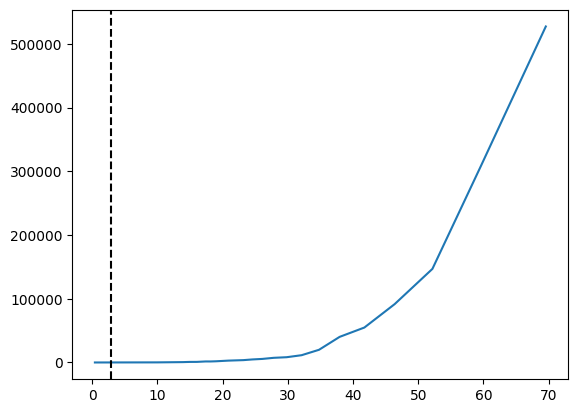

In [175]:



radius_min_index = 3
radius_max_index = -4

radius_index = -10

x_end_index = np.where(np.flip(spacial_wavelength_mm.value)<=100)[0][-1]
print(x_end_index)

plt.plot(np.flip(spacial_wavelength_mm)[:x_end_index], np.flip(ffts_of_radius[radius_index])[:x_end_index])


In [185]:
spacial_wavelength_073 = spacial_wavelength_073/u.R_sun
spacial_wavelength_097 = spacial_wavelength_097/u.R_sun

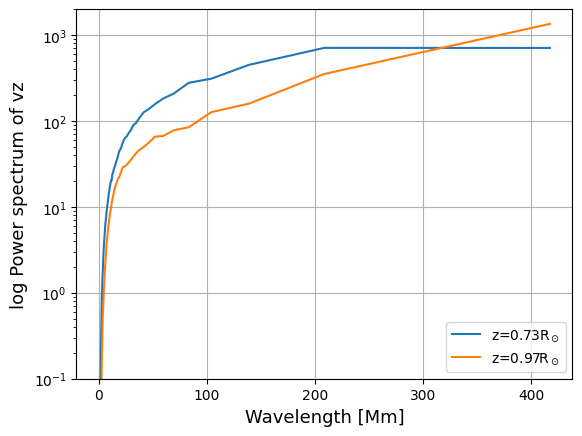

In [186]:
plt.semilogy(spacial_wavelength_073.value, magnitude_spectrum_073, label=r"z=0.73R$_\odot$")
plt.semilogy(spacial_wavelength_097.value, magnitude_spectrum_097, label=r"z=0.97R$_\odot$")
plt.xlabel("Wavelength [Mm]", fontsize=13)
plt.ylabel("log Power spectrum of vz", fontsize=13)
plt.legend(loc="lower right")
plt.grid(True)
plt.ylim(1e-1, 2e3)
plt.savefig("plots_for_thesis/vz_power_spectrum_0.png")

In [26]:
snap_range = range(2400, 2801, 1)

spacial_wavelength_073_2400, magnitude_spectrum_073_2400, _= amplitudes_over_several_snaps(0.73, snap_range, variable_key, normalized=True)

spacial_wavelength_097_2400, magnitude_spectrum_097_2400, _ = amplitudes_over_several_snaps(0.97, snap_range, variable_key, normalized=True)

/tmp/ipykernel_939762/1145139464.py:11: RuntimeWarning: invalid value encountered in divide
  vz = vz/(np.sqrt(np.mean(vz**2, axis=1))[:,np.newaxis])


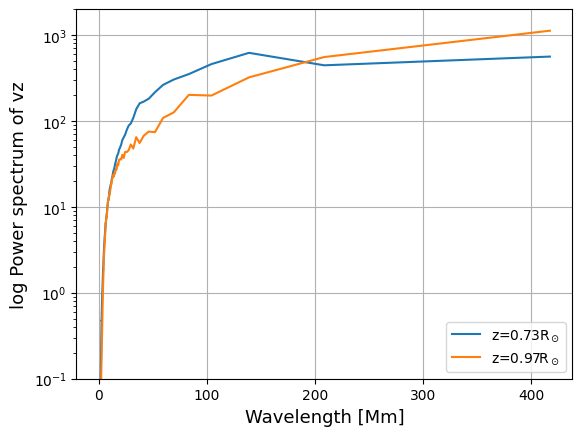

In [188]:
#spacial_wavelength_073_2400 = spacial_wavelength_073_2400 * u.R_sun
#spacial_wavelength_097_2400 = spacial_wavelength_097_2400 * u.R_sun
#spacial_wavelength_073_2400 = spacial_wavelength_073_2400.to(u.Mm)
#spacial_wavelength_097_2400 = spacial_wavelength_097_2400.to(u.Mm)

plt.semilogy(spacial_wavelength_073_2400.value, magnitude_spectrum_073_2400, label=r"z=0.73R$_\odot$")
plt.semilogy(spacial_wavelength_097_2400.value, magnitude_spectrum_097_2400, label=r"z=0.97R$_\odot$")
plt.xlabel("Wavelength [Mm]", fontsize=13)
plt.ylabel("log Power spectrum of vz", fontsize=13)
plt.legend(loc="lower right")
plt.grid(True)
plt.ylim(1e-1, 2e3)
plt.savefig("plots_for_thesis/vz_power_spectrum_1.png")

In [28]:
snap_range = range(3100, 3201, 1)

spacial_wavelength_073_3100, magnitude_spectrum_073_3100, _= amplitudes_over_several_snaps(0.73, snap_range, variable_key, normalized=True)

spacial_wavelength_097_3100, magnitude_spectrum_097_3100, _ = amplitudes_over_several_snaps(0.97, snap_range, variable_key, normalized=True)

/tmp/ipykernel_939762/1145139464.py:11: RuntimeWarning: invalid value encountered in divide
  vz = vz/(np.sqrt(np.mean(vz**2, axis=1))[:,np.newaxis])


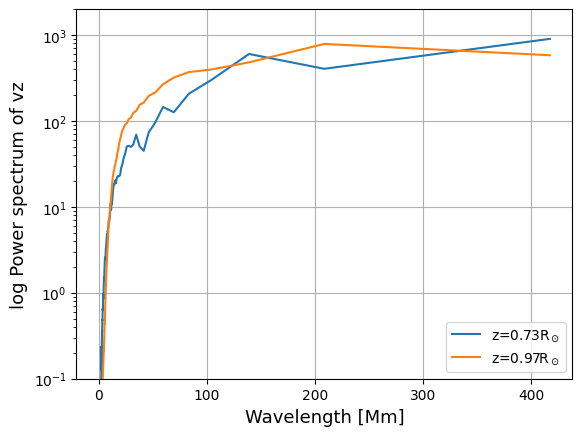

In [189]:
spacial_wavelength_073_3100 = spacial_wavelength_073_3100 * u.R_sun
spacial_wavelength_097_3100 = spacial_wavelength_097_3100 * u.R_sun
spacial_wavelength_073_3100 = spacial_wavelength_073_3100.to(u.Mm)
spacial_wavelength_097_3100 = spacial_wavelength_097_3100.to(u.Mm)

plt.semilogy(spacial_wavelength_073_3100.value, magnitude_spectrum_073_3100, label=r"z=0.73R$_\odot$")
plt.semilogy(spacial_wavelength_097_3100.value, magnitude_spectrum_097_3100, label=r"z=0.97R$_\odot$")
plt.xlabel("Wavelength [Mm]", fontsize=13)
plt.ylabel("log Power spectrum of vz", fontsize=13)
plt.legend(loc="lower right")
plt.grid(True)
plt.ylim(1e-1, 2e3)
plt.savefig("plots_for_thesis/vz_power_spectrum_2.png")

/tmp/ipykernel_1240049/1268800646.py:11: RuntimeWarning: invalid value encountered in divide
  vz = vz/(np.sqrt(np.mean(vz**2, axis=1))[:,np.newaxis])


Text(0, 0.5, 'log Power spectrum of vz')

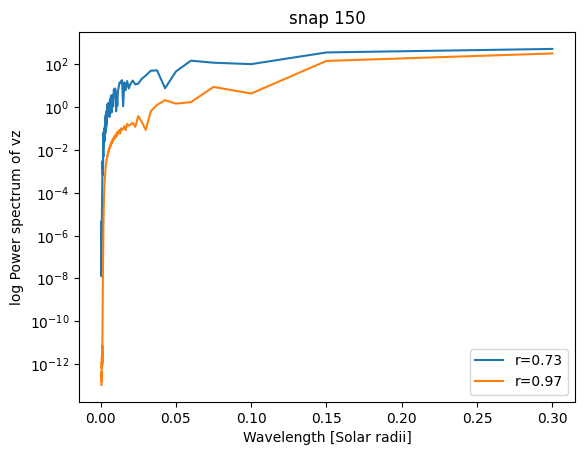

In [4]:
snap = 150
spacial_wl, magnitude_spectrum = get_vz_fft(0.73, snap, variable_key, normalized=True)
plt.semilogy(spacial_wl, magnitude_spectrum, label="r=0.73")
spacial_wl, magnitude_spectrum = get_vz_fft(0.97, snap, variable_key, normalized=True)
plt.semilogy(spacial_wl, magnitude_spectrum, label="r=0.97")
plt.legend()
plt.title(f"snap {snap}")
#plt.axvline(0.07, color="black", linestyle="--", label="0.14")
plt.xlabel("Wavelength [Solar radii]")
plt.ylabel("log Power spectrum of vz")

/tmp/ipykernel_939762/3689223589.py:11: RuntimeWarning: invalid value encountered in divide
  vz = vz/(np.sqrt(np.mean(vz**2, axis=1))[:,np.newaxis])


Text(0, 0.5, 'log Power spectrum of vz')

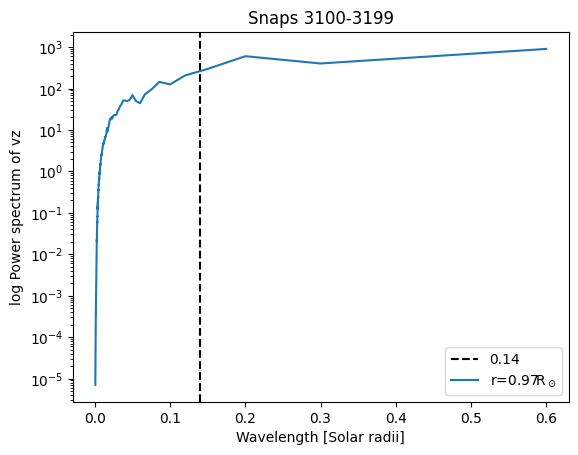

In [14]:
snap_range = range(3100, 3200, 1)
spacial_wl, magnitude_spectrum, _ = amplitudes_over_several_snaps(0.73, snap_range, variable_key, normalized=True)


(0.1, 1000.0)

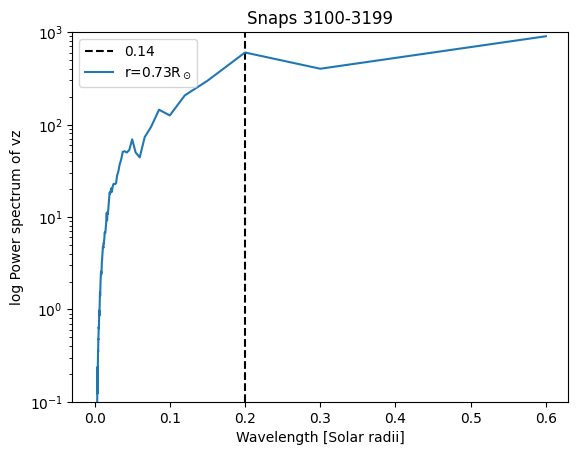

In [21]:
plt.axvline(0.2, color="black", linestyle="--", label="0.14")
plt.semilogy(spacial_wl, magnitude_spectrum, label=r"r=0.73R$_\odot$")
plt.legend()
plt.title(f"Snaps {snap_range[0]}-{snap_range[-1]}")
plt.xlabel("Wavelength [Solar radii]")
plt.ylabel("log Power spectrum of vz")
plt.ylim(1e-1, 1e3)

In [13]:
snap_range = range(3100, 3200, 1)
spacial_wl, magnitude_spectrum, _ = amplitudes_over_several_snaps(0.73, snap_range, variable_key, normalized=True)
plt.semilogy(spacial_wl, magnitude_spectrum, label=r"r=0.73R$_\odot$")
spacial_wl, magnitude_spectrum, _ = amplitudes_over_several_snaps(0.97, snap_range, variable_key, normalized=True)
plt.semilogy(spacial_wl, magnitude_spectrum, label=r"r=0.97R$_\odot$")
plt.legend()
plt.title(f"Snaps {snap_range[0]}-{snap_range[-1]}")
plt.xlabel("Wavelength [Solar radii]")
plt.ylabel("log Power spectrum of vz")
plt.axvline(0.14, color="black", linestyle="--", label="0.14")
#plt.savefig("plots_for_thesis/vz_power_spectrum_1.png")

/tmp/ipykernel_939762/3689223589.py:11: RuntimeWarning: invalid value encountered in divide
  vz = vz/(np.sqrt(np.mean(vz**2, axis=1))[:,np.newaxis])


KeyboardInterrupt: 

In [10]:
(400 * 1000 * u.s).to(u.h)

<Quantity 111.11111111 h>

In [3]:
RUN_NAME = "test_other_ic_3/"

snap = 2500

vy, _, _ = get_foreground_variable(DATA_FOLDER+RUN_NAME, snap, "vy")
vz, _, _ = get_foreground_variable(DATA_FOLDER+RUN_NAME, snap, "vz")
rho1, _, _ = get_foreground_variable(DATA_FOLDER+RUN_NAME, snap, "T1")
constants_dict, global_params_dict, grid_info_dict = get_info(DATA_FOLDER+RUN_NAME)
dz = grid_info_dict["dz"][0]
dx = grid_info_dict["dy"][0]

num_radius, num_horizontal = vz.shape

def apply_fft(data, spacing):
    fft_data = np.fft.fft(data, axis=1)  # FFT along each line of constant radius
    frequencies = np.fft.fftfreq(data.shape[1], d=spacing)  # Calculate spatial frequencies
    return np.abs(fft_data), frequencies

# Applying FFT to the horizontal components of v_z and v_x
fft_magnitude_vz, freqs = apply_fft(vz, dx)
fft_magnitude_vx, _ = apply_fft(vy, dx)  # Frequencies same as for v_z
fft_magnitude_rho1, _ = apply_fft(rho1, dx)  # Frequencies same as for v_z

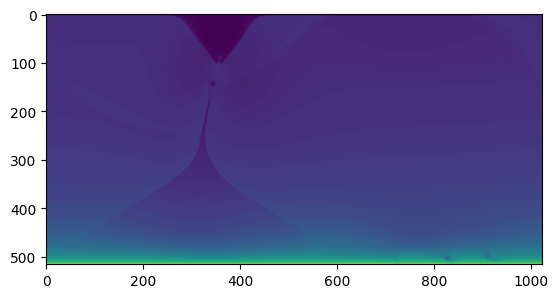

In [29]:
plt.imshow(rho1)

/tmp/ipykernel_1808881/364828783.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(fft_magnitude_vz), aspect='auto', extent=[freqs.min(), freqs.max(), 0, fft_magnitude_rho1.shape[0]], cmap='viridis')


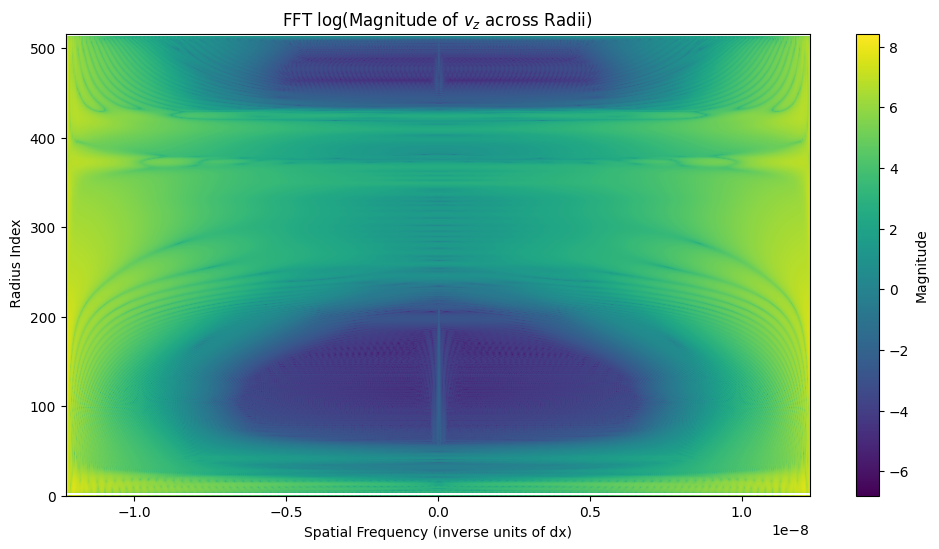

In [69]:
plt.figure(figsize=(12, 6))
plt.imshow(np.log10(fft_magnitude_vz), aspect='auto', extent=[freqs.min(), freqs.max(), 0, fft_magnitude_rho1.shape[0]], cmap='viridis')
plt.colorbar(label='Magnitude')
plt.xlabel('Spatial Frequency (inverse units of dx)')
plt.ylabel(' Radius Index')
plt.title('FFT log(Magnitude of $v_z$ across Radii)')
plt.show()

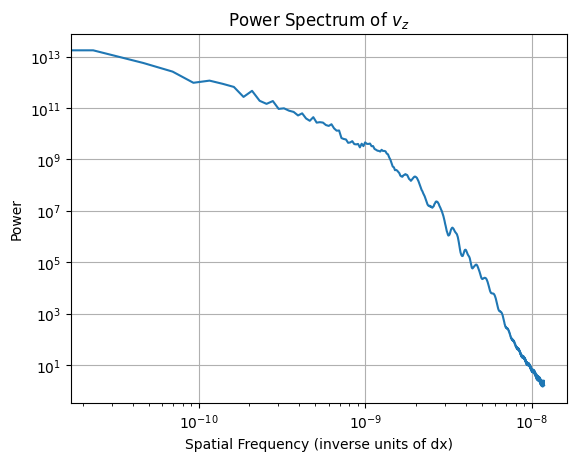

In [27]:
# Perform the FFT on your velocity data vz_grid (which is a 2D array)
fft_vz = np.fft.fft2(vz)

# Calculate the magnitudes of the FFT results
fft_magnitude_vz = np.abs(fft_vz)

# Compute the power spectrum
power_spectrum_vz = fft_magnitude_vz**2

# If needed, normalize the power spectrum by the number of points
normalized_power_spectrum_vz = power_spectrum_vz / np.size(vz)

frequencies = np.fft.fftfreq(vz.shape[1], d=dz)

positive_frequencies = frequencies[:vz.shape[1]//2]

# Average the power spectrum over the radial direction to get a 1D power spectrum for plotting
power_spectrum_vz_1d = np.mean(normalized_power_spectrum_vz, axis=0)
positive_power_spectrum_vz_1d = power_spectrum_vz_1d[:vz.shape[1]//2]


# Assuming 'frequencies' is the array of spatial frequencies from the FFT
plt.loglog(positive_frequencies, positive_power_spectrum_vz_1d)
plt.xlabel('Spatial Frequency (inverse units of dx)')
plt.ylabel('Power')
plt.title('Power Spectrum of $v_z$')
plt.grid(True)
plt.show()

Text(0, 0.5, 'Mean velocity [km/s]')

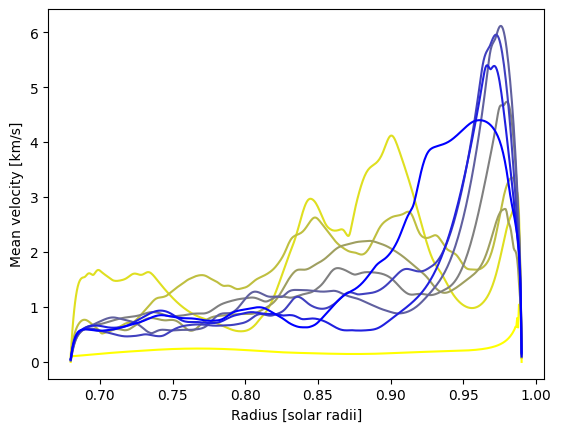

In [79]:
from matplotlib.colors import LinearSegmentedColormap

def plot_mean_velocity_2(snap, cmap):
    vy, _, t = get_foreground_variable(DATA_FOLDER+RUN_NAME, snap, "vy")
    vz, _, _ = get_foreground_variable(DATA_FOLDER+RUN_NAME, snap, "vz")

    t = t*u.s
    t = t.to("day")

    velocity = np.sqrt(vy**2 + vz**2)
    r, _ = get_background_variable(DATA_FOLDER+RUN_NAME, "r")

    velocity = velocity[2:-2]
    r = r[2:-2]

    mean_velocity = np.mean(velocity/1e5, axis=1)
    plt.plot(r/R_SUN.value, mean_velocity, label=f"t = {t:.2f} days", color=cmap)

range_ = range(1, 450, 50)
len_range = len(range_)

colors = ["yellow", "blue"]
cmap = LinearSegmentedColormap.from_list("custom_yellow_blue", colors, N=len_range)

i = 0
for snap in range_:
    plot_mean_velocity_2(snap, cmap(i/(len_range-1)))
    i += 1
plt.xlabel("Radius [solar radii]")
plt.ylabel("Mean velocity [km/s]")
#plt.savefig("plots_for_thesis/velocity_settle.png")

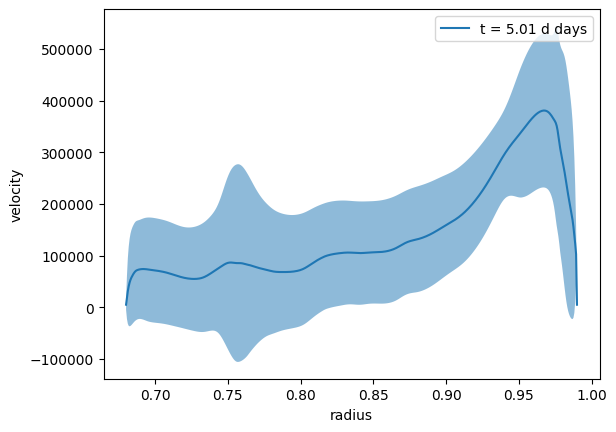

In [80]:
def plot_mean_velocity(snap):
    vy, _, t = get_foreground_variable(DATA_FOLDER+RUN_NAME, snap, "vy")
    vz, _, _ = get_foreground_variable(DATA_FOLDER+RUN_NAME, snap, "vz")

    t = t*u.s
    t = t.to("day")

    velocity = np.sqrt(vy**2 + vz**2)
    r, _ = get_background_variable(DATA_FOLDER+RUN_NAME, "r")

    velocity = velocity[2:-2]
    r = r[2:-2]

    mean_velocity = np.mean(velocity, axis=1)
    std_velocity = np.std(velocity, axis=1)

    plt.plot(r/R_SUN.value, mean_velocity, label=f"t = {t:.2f} days")
    plt.fill_between(r/R_SUN.value, mean_velocity-std_velocity, mean_velocity+std_velocity, alpha=0.5)


for snap in [430]: #[430, 860, 1205, 1721]:
    plot_mean_velocity(snap)

plt.xlabel("radius")
plt.ylabel("velocity")
plt.legend()

# RMS velocity vs. MLT velocity with $\alpha=6$

### MLT velocity

In [190]:
def read_solar_S_hdf5(file_path):
    with h5py.File(file_path, 'r') as f:
        r_over_R = np.array(f['/r_over_R'])
        c_s = np.array(f['/c_s'])
        Gamma_1 = np.array(f['/Gamma_1'])
        T0 = np.array(f['/T']) * u.K
        rho0 = np.array(f['/rho']) * u.g/u.cm**3
        p0 = np.array(f['/p']) * u.dyne/u.cm**2
        
        r_over_R = np.flip(r_over_R)
        c_s = np.flip(c_s)
        Gamma_1 = np.flip(Gamma_1)
        T0 = np.flip(T0)
        rho0 = np.flip(rho0)
        p0 = np.flip(p0)

        variables = {'r_over_R': r_over_R, 'c_s': c_s, 'Gamma_1': Gamma_1, 'T0': T0, 'rho0': rho0, 'p0': p0}
    return variables

solar_S = read_solar_S_hdf5("../additional_files/solar_s.h5")

In [191]:
solar_S['M'] = 4*np.pi*R_SUN**3 * cumtrapz(solar_S['rho0']*(solar_S['r_over_R'])**2, solar_S['r_over_R'], initial=0) * u.g / u.cm**3
solar_S['M'] = solar_S['M'].to(u.g)
solar_S['g'] = -G*solar_S['M']/((solar_S['r_over_R']*R_SUN)**2)
solar_S['g'] = solar_S['g'].to(u.cm/u.s**2)

solar_S['dr'] = (np.roll(solar_S['r_over_R'], -1) - np.roll(solar_S['r_over_R'], 1)) * R_SUN/2
solar_S['dp'] = (np.roll(solar_S['p0'], -1) - np.roll(solar_S['p0'], 1))/2
solar_S['dT'] = (np.roll(solar_S['T0'], -1) - np.roll(solar_S['T0'], 1))/2

solar_S['H'] = -solar_S['p0'] * solar_S['dr']/solar_S['dp']
solar_S['H'] = solar_S['H'].to(u.cm)

solar_S['dT/dp'] = solar_S['dT']/solar_S['dp']

del_star = solar_S['p0']/solar_S['T0'] * solar_S['dT/dp']

delta = 1

def get_v_mlt(alpha):
    kappa = (1 * u.m**2/u.g).to(u.cm**2/u.g)

    l_m = alpha * solar_S['H']

    sigma = 5.67e-5 * u.erg/u.cm**2/u.s/u.K**4

    U = 64 * sigma * solar_S['T0']**3/3/kappa/solar_S['rho0']**2/c_p * np.sqrt(-solar_S['H']/solar_S['g']/delta)

    R = U/l_m**2
    K = 4*R
    del_ad = 0.4

    rhs = -0.5*K + np.sqrt((0.5*K)**2 + (del_star-del_ad)**2)

    del_p = del_star - rhs**2

    v_mlt = np.sqrt(-solar_S['g']*delta/solar_S['H'])*(l_m)/2 * (del_star - del_p)**(1/2)
    return v_mlt

/uio/hume/student-u58/tabjone/.local/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


### RMS velocity

In [192]:
def get_rms_velocity(folder, snap):
    vz, unit, t = get_foreground_variable(DATA_FOLDER+RUN_NAME, snap, "vz")
    vz = vz * u.Unit(unit)
    vy, unit, _ = get_foreground_variable(DATA_FOLDER+RUN_NAME, snap, "vy")
    vy = vy * u.Unit(unit)

    v = np.sqrt(vz**2 + vy**2)
    v_rms = np.sqrt(np.mean(v**2, axis=1))/1e5
    return v_rms

In [193]:
RUN_NAME = "test_other_ic_4/"
r, unit = get_background_variable(DATA_FOLDER+RUN_NAME, "r")
r = r * u.Unit(unit)

v_rms_snaps = []

for snap in range(450, 1550, 10):
    vz, unit, t = get_foreground_variable(DATA_FOLDER+RUN_NAME, snap, "vz")
    vz = vz * u.Unit(unit)
    vy, unit, _ = get_foreground_variable(DATA_FOLDER+RUN_NAME, snap, "vy")
    vy = vy * u.Unit(unit)

    v = np.sqrt(vz**2 + vy**2)[2:-2]
    v_rms = np.sqrt(np.mean(v**2, axis=1))/1e5
    v_rms_snaps.append(v_rms)

r, unit = get_background_variable(DATA_FOLDER+RUN_NAME, "r")
r = r * u.Unit(unit)
r = r[2:-2]

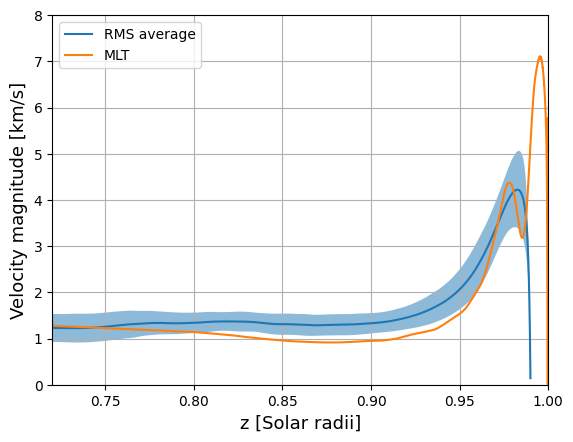

In [195]:
v_rms_snaps = np.array(v_rms_snaps)
v_rms = np.mean(v_rms_snaps, axis=0)
v_std = np.std(v_rms_snaps, axis=0)

plt.plot(r/R_SUN, v_rms, label="RMS average")
plt.fill_between(r/R_SUN, (v_rms-v_std), (v_rms+v_std), alpha=0.5)
plt.plot(solar_S['r_over_R'], get_v_mlt(4)/1e5, label="MLT")
plt.xlabel("z [Solar radii]", fontsize=13)
plt.ylabel("Velocity magnitude [km/s]", fontsize=13)
plt.legend()
plt.xlim(0.72, 1.0)
plt.ylim(0, 8)
plt.grid(True)
plt.savefig("plots_for_thesis/rms_vs_mlt.png")

# Convective flux

### Numerical convective flux

In [42]:
rho1, unit, t = get_foreground_variable(DATA_FOLDER+RUN_NAME, 1550, 'T1')
t = t*u.s
t = t.to('day')
print(t)

17.99381148044842 d


In [178]:
rho0, unit = get_background_variable(DATA_FOLDER+RUN_NAME, "rho0")
rho0 = rho0 * u.Unit(unit)
r, unit = get_background_variable(DATA_FOLDER+RUN_NAME, "r")
r = r * u.Unit(unit)

def get_convective_flux(snap_range=range(450, 1550, 10)):
    convective_flux = []
    
    for snap in snap_range:
        rho1, unit, t = get_foreground_variable(DATA_FOLDER+RUN_NAME, snap, "rho1")
        rho1 = rho1 * u.Unit(unit)
        vz, unit, _ = get_foreground_variable(DATA_FOLDER+RUN_NAME, snap, "vz")
        vz = vz * u.Unit(unit)

        T1, unit, _ = get_foreground_variable(DATA_FOLDER+RUN_NAME, snap, "T1")
        T1 = T1 * u.Unit(unit)

        rho = rho0[:,np.newaxis] + rho1

        flux = rho * c_p * vz * T1
        positive_flux = flux[flux > 0]
        negative_flux = flux[flux <= 0]
        positive_flux = np.mean(positive_flux, axis=1)
        negative_flux = np.mean(negative_flux, axis=1)

        convective_flux.append(positive_flux + negative_flux)
    
    convective_flux = np.array(convective_flux)
    mean_convection = np.mean(convective_flux, axis=0)
    std_convection = np.std(convective_flux, axis=0)
    return mean_convection, std_convection

In [167]:
rho0, unit = get_background_variable(DATA_FOLDER+RUN_NAME, "rho0")
rho0 = rho0 * u.Unit(unit)
r, unit = get_background_variable(DATA_FOLDER+RUN_NAME, "r")
r = r * u.Unit(unit)

F_con_num_mean_negative_list = []
F_con_num_mean_positive_list = []
F_con_num_mean_total_list = []

for snap in range(450, 1550, 10):
    rho1, unit, t = get_foreground_variable(DATA_FOLDER+RUN_NAME, snap, "rho1")
    rho1 = rho1 * u.Unit(unit)
    vz, unit, _ = get_foreground_variable(DATA_FOLDER+RUN_NAME, snap, "vz")
    # find where vz < 0 and set vz=0 there
    vz_positive = np.copy(vz)
    vz_negative = np.copy(vz)

    vz_positive[vz > 0] = 0
    vz_negative[vz <= 0] = 0

    vz_positive = vz_positive * u.Unit(unit)
    vz_negative = vz_negative * u.Unit(unit)
    vz = vz * u.Unit(unit)

    T1, unit, _ = get_foreground_variable(DATA_FOLDER+RUN_NAME, snap, "T1")
    T1 = T1 * u.Unit(unit)

    rho = rho0[:,np.newaxis] + rho1

    F_con_num_positive = rho * c_p * vz_positive * T1
    F_con_num_positive_mean = np.mean(F_con_num_positive, axis=1)
    F_con_num_mean_positive_list.append(F_con_num_positive_mean)

    F_con_num_negative = rho * c_p * vz_negative * T1
    F_con_num_negative_mean = np.mean(F_con_num_negative, axis=1)
    F_con_num_mean_negative_list.append(F_con_num_negative_mean)

    F_con_num_total_mean = F_con_num_positive_mean + F_con_num_negative_mean
    F_con_num_mean_total_list.append(F_con_num_total_mean)

F_con_num_mean_positive_list = np.array(F_con_num_mean_positive_list)
F_con_num_mean_positive = np.mean(F_con_num_mean_positive_list, axis=0)
F_con_num_positive_std = np.std(F_con_num_mean_positive_list, axis=0)
F_con_num_mean_negative_list = np.array(F_con_num_mean_negative_list)
F_con_num_mean_negative = np.mean(F_con_num_mean_negative_list, axis=0)
F_con_num_negative_std = np.std(F_con_num_mean_negative_list, axis=0)
F_con_num_mean_total_list = np.array(F_con_num_mean_total_list)
F_con_num_mean_total = np.mean(F_con_num_mean_total_list, axis=0)
F_con_num_total_std = np.std(F_con_num_mean_total_list, axis=0)

In [180]:
rho0, unit = get_background_variable(DATA_FOLDER+RUN_NAME, "rho0")
rho0 = rho0 * u.Unit(unit)
r, unit = get_background_variable(DATA_FOLDER+RUN_NAME, "r")
r = r * u.Unit(unit)

F_con_num_mean_negative_list = []
F_con_num_mean_positive_list = []
F_con_num_mean_total_list = []

flux_positive_list = []
flux_negative_list = []
flux_total_list = []


for snap in range(450, 1550, 10):
    rho1, unit, t = get_foreground_variable(DATA_FOLDER+RUN_NAME, snap, "rho1")
    rho1 = rho1 * u.Unit(unit)
    vz, unit, _ = get_foreground_variable(DATA_FOLDER+RUN_NAME, snap, "vz")
    # find where vz < 0 and set vz=0 there
    vz = vz * u.Unit(unit)

    T1, unit, _ = get_foreground_variable(DATA_FOLDER+RUN_NAME, snap, "T1")
    T1 = T1 * u.Unit(unit)

    rho = rho0[:,np.newaxis] + rho1

    flux = rho * c_p * vz * T1
    positive_flux = np.copy(flux)
    negative_flux = np.copy(flux)

    positive_flux[vz >= 0] = 0
    negative_flux[vz < 0] = 0
    positive_flux = np.mean(positive_flux, axis=1)
    negative_flux = np.mean(negative_flux, axis=1)
    
    total_flux = positive_flux + negative_flux

    flux_positive_list.append(positive_flux)
    flux_negative_list.append(negative_flux)
    flux_total_list.append(total_flux)

flux_positive_list = np.array(flux_positive_list)
flux_negative_list = np.array(flux_negative_list)
flux_total_list = np.array(flux_total_list)

flux_positive_mean = np.mean(flux_positive_list, axis=0)
flux_positive_std = np.std(flux_positive_list, axis=0)
flux_negative_mean = np.mean(flux_negative_list, axis=0)
flux_negative_std = np.std(flux_negative_list, axis=0)
flux_total_mean = np.mean(flux_total_list, axis=0)
flux_total_std = np.std(flux_total_list, axis=0)

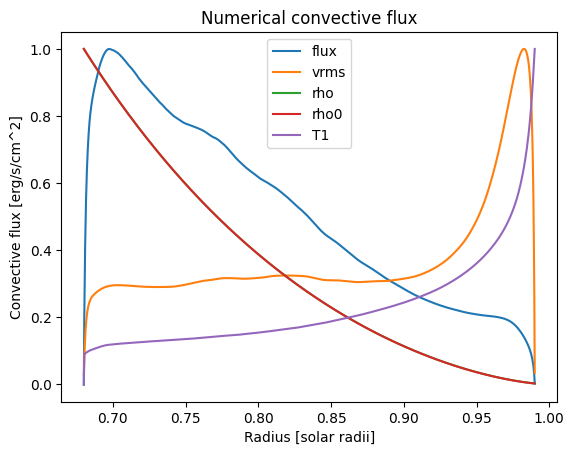

In [174]:
#plt.plot(r[2:-2]/R_SUN, flux_positive_mean[2:-2], label="Positive")
plt.plot(r[2:-2]/R_SUN, flux_negative_mean[2:-2]/np.max(np.abs(flux_negative_mean[2:-2])), label="flux")
plt.plot(r[2:-2]/R_SUN, v_rms_mean[2:-2]/np.max(np.abs(v_rms_mean[2:-2])), label="vrms")
plt.plot(r[2:-2]/R_SUN, rho_mean[2:-2]/np.max(np.abs(rho_mean[2:-2])), label="rho")
plt.plot(r[2:-2]/R_SUN, rho0[2:-2]/np.max(np.abs(rho0[2:-2])), label="rho0")
plt.plot(r[2:-2]/R_SUN, T1_mean[2:-2]/np.max(np.abs(T1_mean[2:-2])), label="T1")
plt.xlabel("Radius [solar radii]")
plt.ylabel("Convective flux [erg/s/cm^2]")
plt.title("Numerical convective flux")
plt.legend()

### Analytical convective flux

/tmp/ipykernel_939762/1138179592.py:31: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 5000)


(0.00020320505494975867, 5000)

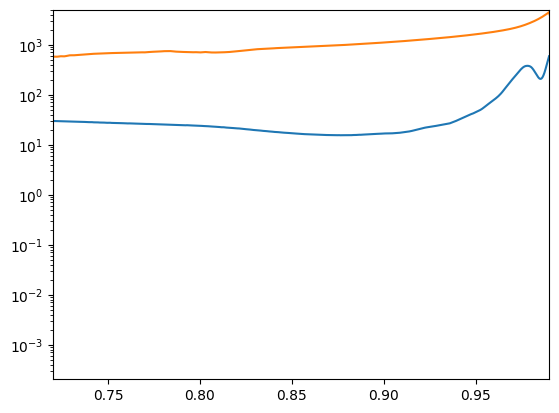

In [162]:
kappa = (1 * u.m**2/u.g).to(u.cm**2/u.g)

l_m = 4 * solar_S['H']

sigma = 5.67e-5 * u.erg/u.cm**2/u.s/u.K**4

U = 64 * sigma * solar_S['T0']**3/3/kappa/solar_S['rho0']**2/c_p * np.sqrt(-solar_S['H']/solar_S['g']/delta)

R = U/l_m**2
K = 4*R
del_ad = 0.4

rhs = -0.5*K + np.sqrt((0.5*K)**2 + (del_star-del_ad)**2)

del_p = del_star - rhs**2

v_mlt = np.sqrt(-solar_S['g']*delta/solar_S['H'])*(l_m)/2 * (del_star - del_p)**(1/2)

rho = solar_S['rho0']
T = solar_S['T0']
Hp = solar_S['H']

F_con_an = rho * c_p * v_mlt * T * l_m / 2 / Hp * (del_star - del_p)

T1, _, _ = get_foreground_variable(DATA_FOLDER+RUN_NAME, 1550, "T1")
r, _ = get_background_variable(DATA_FOLDER+RUN_NAME, "r")

plt.semilogy(solar_S['r_over_R'], T*(del_star - del_p), label="T*(del_star - del_p)")
plt.semilogy(r/R_SUN, np.mean(T1, axis=1))
plt.xlim(0.72, 0.99)
plt.ylim(0, 5000)

In [46]:
def get_flux_mlt(alpha):
    kappa = (1 * u.m**2/u.g).to(u.cm**2/u.g)

    l_m = alpha * solar_S['H']

    sigma = 5.67e-5 * u.erg/u.cm**2/u.s/u.K**4

    U = 64 * sigma * solar_S['T0']**3/3/kappa/solar_S['rho0']**2/c_p * np.sqrt(-solar_S['H']/solar_S['g']/delta)

    R = U/l_m**2
    K = 4*R
    del_ad = 0.4

    rhs = -0.5*K + np.sqrt((0.5*K)**2 + (del_star-del_ad)**2)

    del_p = del_star - rhs**2

    v_mlt = np.sqrt(-solar_S['g']*delta/solar_S['H'])*(l_m)/2 * (del_star - del_p)**(1/2)

    rho = solar_S['rho0']
    T = solar_S['T0']
    Hp = solar_S['H']

    F_con_an = rho * c_p * v_mlt * T * l_m / 2 / Hp * (del_star - del_p)
    return F_con_an

In [179]:
mean_convective_flux, std_convective_flux = get_convective_flux()

AxisError: axis 1 is out of bounds for array of dimension 1

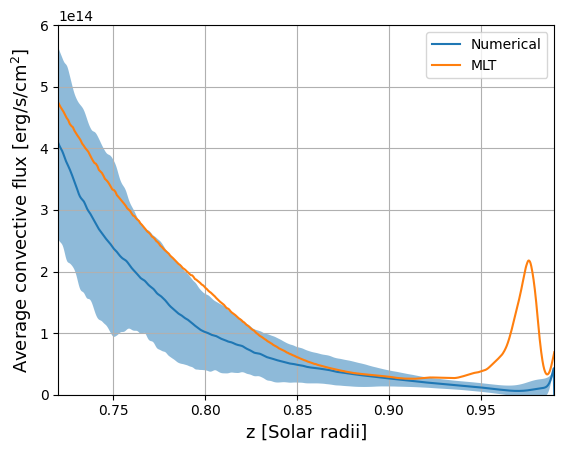

In [182]:
#total flux
plt.plot(r[2:-2]/R_SUN, np.abs(flux_total_mean[2:-2]), label="Numerical")
#total flux std
plt.fill_between(r[2:-2]/R_SUN, (np.abs(flux_total_mean[2:-2])-flux_total_std[2:-2]), (np.abs(flux_total_mean[2:-2])+flux_total_std[2:-2]), alpha=0.5)

#mlt
plt.plot(solar_S['r_over_R'], get_flux_mlt(4), label="MLT")

plt.xlim(0.72, 0.99)
plt.ylim(0.0e15, 0.6e15)
plt.xlabel("z [Solar radii]", fontsize=13)
plt.ylabel(r"Average convective flux [erg/s/cm$^2$]", fontsize=13)
plt.legend()
plt.grid(True)
plt.savefig("plots_for_thesis/convective_flux.png")

In [248]:
F_con_an.unit

Unit("erg / (s cm2)")

Text(0, 0.5, 'velocity')

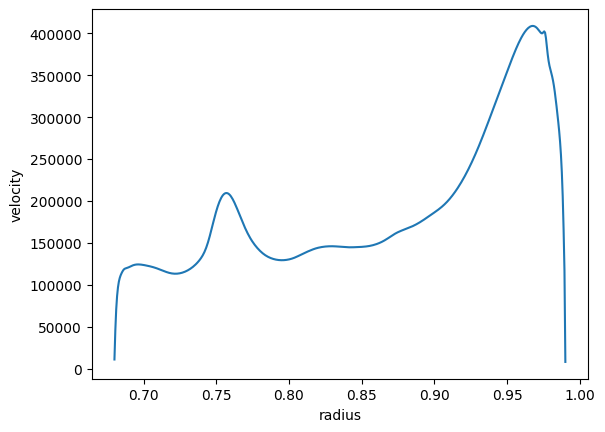

In [70]:
def plot_rms_velocity(snap):
    vy, _, t = get_foreground_variable(DATA_FOLDER+RUN_NAME, snap, "vy")
    vz, _, _ = get_foreground_variable(DATA_FOLDER+RUN_NAME, snap, "vz")

    t = t*u.s
    t = t.to("day")

    velocity = np.sqrt(vy**2 + vz**2)
    r, _ = get_background_variable(DATA_FOLDER+RUN_NAME, "r")

    velocity = velocity[2:-2]
    r = r[2:-2]

    rms_velocity = np.sqrt(np.mean(velocity**2, axis=1))

    plt.plot(r/R_SUN.value, rms_velocity, label=f"t = {t:.2f} days")


for snap in [430]: #[430, 860, 1205, 1721]:
    plot_rms_velocity(snap)

plt.xlabel("radius")
plt.ylabel("velocity")

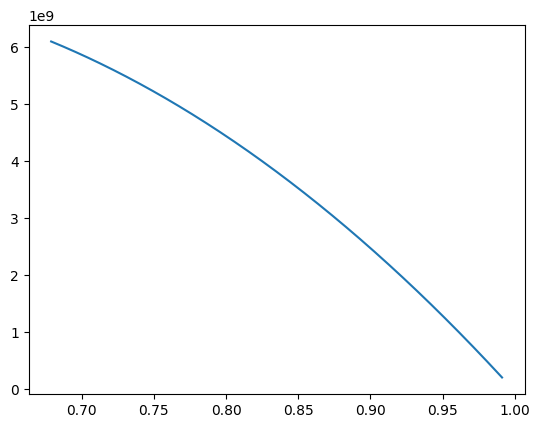

In [6]:
np.exp(-1000)

0.0

In [9]:
np.exp((stress-90))

array([8.19401262e-40, 9.05669098e-40, 1.00101935e-39, 1.10640822e-39,
       1.22289259e-39, 1.35164062e-39, 1.49394344e-39, 1.65122812e-39,
       1.82507198e-39, 2.01721839e-39, 2.22959427e-39, 2.46432941e-39,
       2.72377784e-39, 3.01054140e-39, 3.32749586e-39, 3.67781979e-39,
       4.06502636e-39, 4.49299864e-39, 4.96602851e-39, 5.48885970e-39,
       6.06673536e-39, 6.70545067e-39, 7.41141092e-39, 8.19169576e-39,
       9.05413020e-39, 1.00073631e-38, 1.10609538e-38, 1.22254682e-38,
       1.35125844e-38, 1.49352103e-38, 1.65076124e-38, 1.82455594e-38,
       2.01664802e-38, 2.22896385e-38, 2.46363262e-38, 2.72300769e-38,
       3.00969016e-38, 3.32655501e-38, 3.67677988e-38, 4.06387697e-38,
       4.49172825e-38, 4.96462436e-38, 5.48730772e-38, 6.06501999e-38,
       6.70355470e-38, 7.40931534e-38, 8.18937955e-38, 9.05157014e-38,
       1.00045335e-37, 1.10578263e-37, 1.22220114e-37, 1.35087637e-37,
       1.49309873e-37, 1.65029448e-37, 1.82404005e-37, 2.01607781e-37,
      

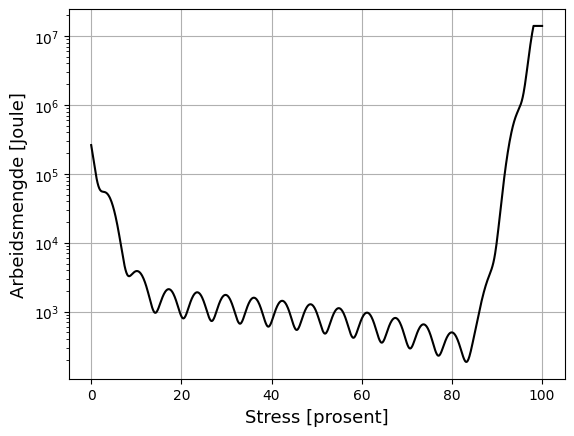

In [50]:
import numpy as np
import matplotlib.pyplot as plt

stress = np.linspace(0,100, 1000)

func = (5+500*np.exp((stress-90)))
func *= (np.exp((10-stress)/2)+1)
func *= (1-0.3*(np.sin(stress)+1))
func *= 5*stress[-1]-5*stress
func[980:-1] = func[980]
func[-1] = func[-2]
plt.semilogy(stress, func, color="black")
plt.xlabel("Stress [prosent]", fontsize=13)
plt.ylabel("Arbeidsmengde [Joule]", fontsize=13)
plt.grid(True)